<a href="https://colab.research.google.com/github/ricardoricrob76/machinelearning/blob/main/DEEP_Varias_Praticas_Regressao_Classificao_Clusterizacao_CNN_Praticas-40-Redes-Neurais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependências

In [ ]:
!pip install tensorflow-gpu==2.0.0-alpha0

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from sklearn.datasets.samples_generator import make_blobs, make_circles, make_moons, make_classification, make_regression
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

print(tf.__version__)

2.6.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
#@title
def plot_random_batch(batch, y_true, y_pred=None, batch_size=30, n_cols=10, figsize=(20, 10)):
    plt.figure(figsize=figsize)

    random_idx = np.random.choice(batch.shape[0], size=batch_size)
    x_batch = batch[random_idx].squeeze()
    y_batch = y_true[random_idx]
    
    y_pred = y_batch if y_pred is None else y_pred[random_idx]
    n_rows = x_batch.shape[0] // n_cols + 1
    is_gray = (batch.shape[-1] == 1 or batch.ndim == 3)
    for img, true, pred, sub in zip(x_batch, y_batch, y_pred, range(1, len(batch)+1)):
        plt.subplot(n_rows, n_cols, sub)
        plt.imshow(img.astype(np.uint8), cmap='gray' if is_gray else None)
        
        plt.title("T:{} P:{}".format(true, pred), color = 'green' if true == pred else 'red')
        plt.axis('off')
    plt.tight_layout()
    
def make_cubic(n_samples, x_min, x_max, a=1, b=0, c=0, d=0, noise=0.0, random_state=None):
    np.random.seed(random_state)
    x = np.linspace(x_min, x_max, n_samples)
    y = a*x**3 + b*x**2 + c*x + d + (2*noise*np.random.random(n_samples) - noise)
    return x.reshape(-1,1), y.reshape(-1,1)

def make_exp(n_samples, x_min, x_max, noise=0.0, random_state=None):
    np.random.seed(random_state)
    x = np.linspace(x_min, x_max, n_samples)
    y = np.exp(x) + 2*noise*np.random.random(n_samples) - noise
    return x.reshape(-1,1), y.reshape(-1,1)
    
def make_log10(n_samples, x_min, x_max, noise=0.0, random_state=None):
    np.random.seed(random_state)
    x = np.logspace(np.log10(x_min), np.log10(x_max), n_samples)
    y = np.log10(x) + 2*noise*np.random.random(n_samples) - noise
    return x.reshape(-1,1), y.reshape(-1,1)

def make_square(n_samples, x_min, x_max, a=1, b=0, c=0, noise=0.0, random_state=None):
    np.random.seed(random_state)
    x = np.linspace(x_min, x_max, n_samples)
    y = a*x**2 + b*x + c + (2*noise*np.random.random(n_samples) - noise)
    return x.reshape(-1,1), y.reshape(-1,1)
    
def make_spiral(n_samples, n_class=2, radius=1, laps=1.0, noise=0.0, random_state=None):
    np.random.seed(random_state)
    x = np.zeros((n_samples * n_class, 2))
    y = np.zeros((n_samples * n_class))
    
    pi_2 = 2 * np.math.pi
    points = np.linspace(0, 1, n_samples)
    r = points * radius
    t = points * pi_2 * laps
    for label, delta_t in zip(range(n_class), np.arange(0, pi_2, pi_2/n_class)):
        random_noise = (2 * np.random.rand(n_samples) - 1) * noise
        index = np.arange(label*n_samples, (label+1)*n_samples)
        x[index] = np.c_[r * np.sin(t + delta_t) + random_noise,
                         r * np.cos(t + delta_t) + random_noise]
        y[index] = label
    return x, y.reshape(-1, 1)
  
def __softmax(x):
    exp = np.exp(x)
    return exp/np.sum(exp, axis=1, keepdims=True)

def __compute_meshgrid(x, y):
    x_min, x_max, y_min, y_max = x[:, 0].min(), x[:, 0].max(), x[:, 1].min(), x[:, 1].max()
    x1, x2 = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    x_mesh = np.array([x1.ravel(), x2.ravel()]).T
    return x1, x2, x_mesh

def plot_hist_and_predictions(history, x, y, model, s=15, cmap=plt.cm.viridis):
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'])
    plt.xlabel('epochs')
    plt.ylabel('accuracy')

    ax = plt.subplot(1, 2, 2)
    plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=s, cmap=cmap)

    plt.subplot(1, 2, 2, sharex=ax, sharey=ax)
    x1, x2, x_mesh = __compute_meshgrid(x, y)
    y_mesh = model.predict_classes(x_mesh)
    plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=s, cmap=cmap)
    plt.contourf(x1, x2, y_mesh.reshape(x1.shape), cmap=cmap, alpha=0.5)
    
def plot_hist_and_line(history, x, y, model):
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'])
    plt.xlabel('epochs')
    plt.ylabel('loss')

    plt.subplot(1, 2, 2)
    x_test = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    y_pred = model.predict(x_test)
    plt.scatter(x, y)
    plt.plot(x_test, y_pred, color='green')
    plt.xlabel('x')
    plt.ylabel('y')

# Regressão

## Regressão Linear

(100, 1) (100, 1)


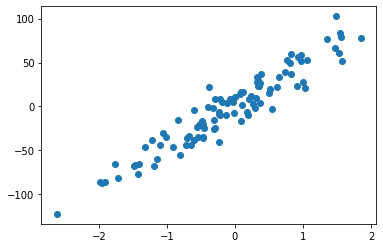

In [ ]:
x, y = make_regression(n_samples=100, n_features=1, noise=15, random_state=42)
y = y.reshape(-1, 1)
print(x.shape, y.shape)

plt.scatter(x, y)

In [ ]:
# 1 Passo - um Definir um modelo.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
4/4 [==============================] - 3s 5ms/step - loss: 1707.1073
Epoch 2/50
4/4 [==============================] - 0s 4ms/step - loss: 925.4833
Epoch 3/50
4/4 [==============================] - 0s 4ms/step - loss: 541.1125
Epoch 4/50
4/4 [==============================] - 0s 5ms/step - loss: 362.0366
Epoch 5/50
4/4 [==============================] - 0s 5ms/step - loss: 259.7531
Epoch 6/50
4/4 [==============================] - 0s 4ms/step - loss: 231.2521
Epoch 7/50
4/4 [==============================] - 0s 4ms/step - loss: 206.5634
Epoch 8/50
4/4 [==============================] - 0s 4ms/step - loss: 196.1902
Epoch 9/50
4/4 [==============================] - 0s 4ms/step - loss: 186.3147
Epoch 10/50
4/4 [==============================] - 0s 6ms/step - loss: 184.1987
Epoch 11/50
4/4 [==============================] - 0s 4ms/step - loss: 180.8631
Epoch 12/50
4/4 [==============================] - 0s 6ms/step - loss: 178.8696
Epoch 13/50
4/4 [==============================]

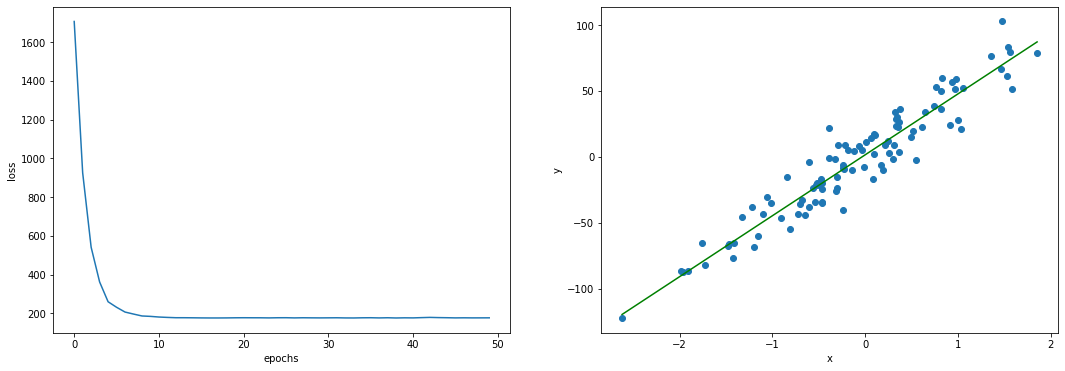

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=1, activation='linear', input_shape=(1, )))  # Adicionando uma camada Densa igual - criando novas Layers.. passando apenas 01 neurônio.. definir o shape da sua entrada

model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.05), loss='mse')  # Compilando a nossa Rede {Optimizer - Loss (perda) mse é saída real mais saída predita.. - Metrics (métrica para avaliar)}

hist = model.fit(x, y, epochs=50)  # Treinamento do Modelo de Deep Learning..

plot_hist_and_line(hist.history, x, y, model)

## Regressão Quadrática

In [ ]:
x, y = make_square(n_samples=100, x_min=-10, x_max=10, a=1, b=1, c=1, noise=10)
print(x.shape, y.shape)

plt.scatter(x, y)

minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float32))

#plt.scatter(x, y)

NameError: ignored

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 20,601
Trainable params: 20,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
100/100 [==============================] - 0s 1ms/sample - loss: 2260.7735
Epoch 2/500
100/100 [==============================] - 0s 101us/sample - loss: 2246.4164
Epoch 3/500
100/100 [==============================] - 0s 91us/sample - loss: 2232.6952
Epoch 4/500
100/100 [==============================] - 0s 114us/sample - loss: 2217.8465
Epoch 5/500
100/100 [======

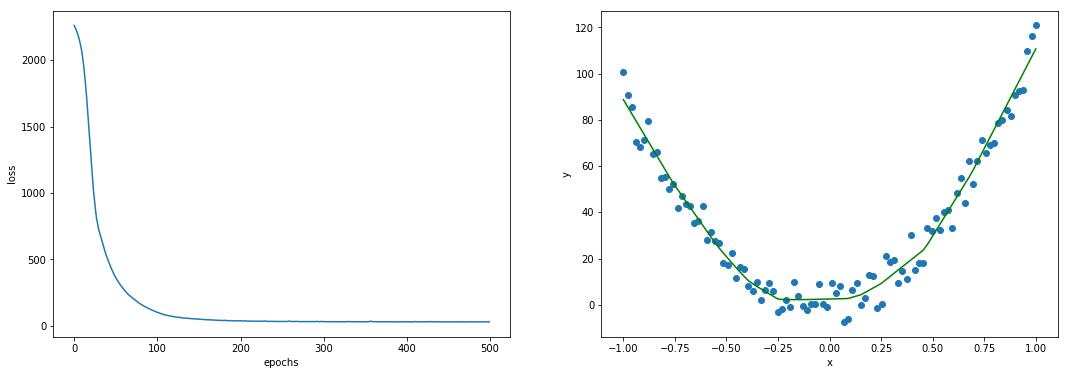

In [ ]:
model = tf.keras.models.Sequential()     # Normalização é muito importante para definir as entradas em colunas baseadas no classificador e na regressão. / Média e Desvio Padrão de Cada coluna 
model.add(tf.keras.layers.Dense(units=200, activation='relu', input_shape=(1, ))) # RELU - Unidade Linear Retificada.. y = max(0,x)
model.add(tf.keras.layers.Dense(units=100, activation='relu'))      # sigmoid
#model.add(tf.keras.layers.Dense(units=100, activation='relu'))      # elu
#model.add(tf.keras.layers.Dense(units=100, activation='relu'))      # tanh
model.add(tf.keras.layers.Dense(units=1, activation='linear'))
model.summary()

model.compile(optimizer='adam', loss='mse')

hist = model.fit(x, y, epochs=500, verbose=1)

plot_hist_and_line(hist.history, x, y, model)

## Regressão Cúbica

(100, 1) (100, 1)


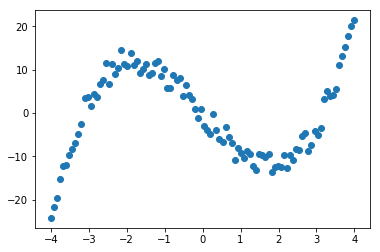

In [ ]:
x, y = make_cubic(n_samples=100, x_min=-4, x_max=4, a=1, b=0, c=-10, d=0, noise=3)
print(x.shape, y.shape)

plt.scatter(x, y)

minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 100)               200       
_________________________________________________________________
dense_63 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_64 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 101       
Total params: 20,501
Trainable params: 20,501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
100/100 [==============================] - 0s 806us/sample - loss: 98.4135
Epoch 2/200
100/100 [==============================] - 0s 94us/sample - loss: 98.2079
Epoch 3/200
100/100 [==============================] - 0s 99us/sample - lo

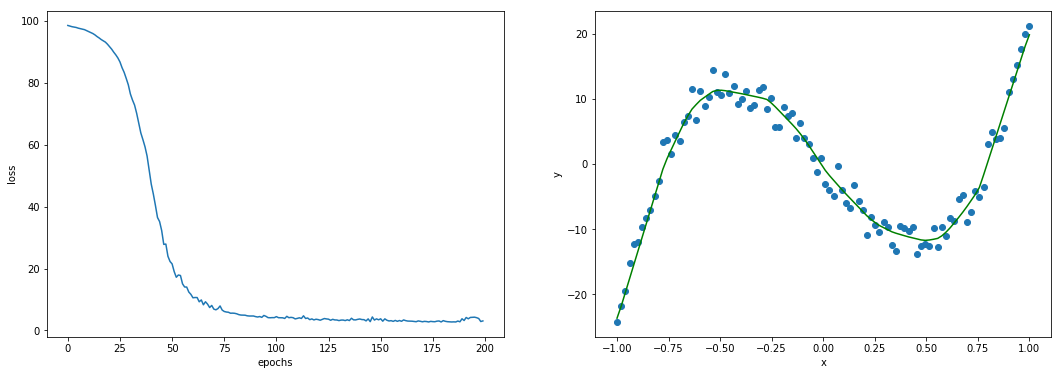

In [ ]:
# Equação de Terceiro Grau ->>> x3 - 10x

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=100, activation='relu', input_shape=(1, )))
model.add(tf.keras.layers.Dense(units=100, activation='relu'))
model.add(tf.keras.layers.Dense(units=100, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='linear'))
model.summary()

model.compile(optimizer='adam', loss='mse')

hist = model.fit(x, y, epochs=200, verbose=1)

plot_hist_and_line(hist.history, x, y, model)

## Regressão Logarítmica

(100, 1) (100, 1)


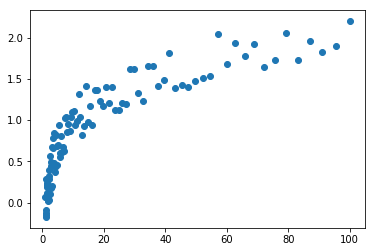

In [ ]:
x, y = make_log10(n_samples=100, x_min=1, x_max=100, noise=0.3)
print(x.shape, y.shape)

plt.scatter(x, y)

minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 100)               200       
_________________________________________________________________
dense_67 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_68 (Dense)             (None, 80)                4080      
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 81        
Total params: 9,411
Trainable params: 9,411
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
100/100 [==============================] - 0s 833us/sample - loss: 1.1577
Epoch 2/100
100/100 [==============================] - 0s 100us/sample - loss: 0.9884
Epoch 3/100
100/100 [==============================] - 0s 72us/sample - loss:

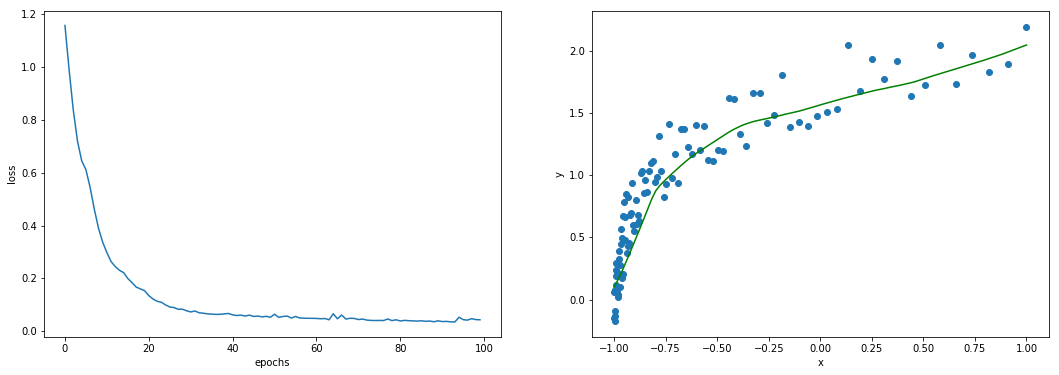

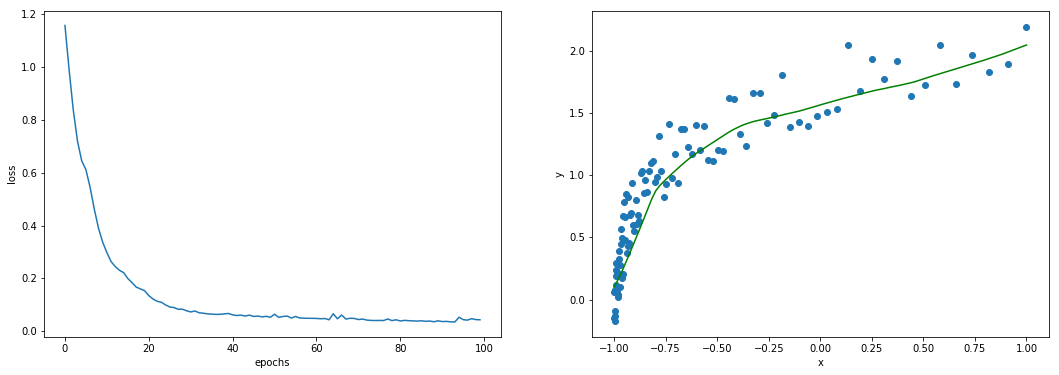

In [ ]:
# Equação de Logaritmica ->>> xxxxxxxxx3 - 10x

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=100, activation='relu', input_shape=(1, )))
model.add(tf.keras.layers.Dense(units=50, activation='relu'))
model.add(tf.keras.layers.Dense(units=80, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='linear'))
model.summary()

model.compile(optimizer='adam', loss='mse')

hist = model.fit(x, y, epochs=100, verbose=1)

plot_hist_and_line(hist.history, x, y, model)

## Regressão Exponencial

(100, 1) (100, 1)


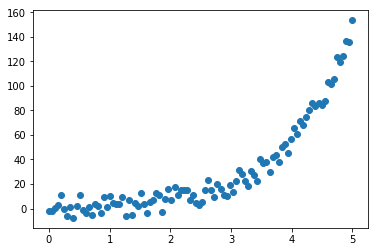

In [ ]:
x, y = make_exp(n_samples=100, x_min=0, x_max=5, noise=10)
print(x.shape, y.shape)

plt.scatter(x, y)

minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_96 (Dense)             (None, 100)               200       
_________________________________________________________________
dense_97 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_98 (Dense)             (None, 180)               18180     
_________________________________________________________________
dense_99 (Dense)             (None, 180)               32580     
_________________________________________________________________
dense_100 (Dense)            (None, 180)               32580     
_________________________________________________________________
dense_101 (Dense)            (None, 1)                 181       
Total params: 93,821
Trainable params: 93,821
Non-trainable params: 0
_________________________________________________

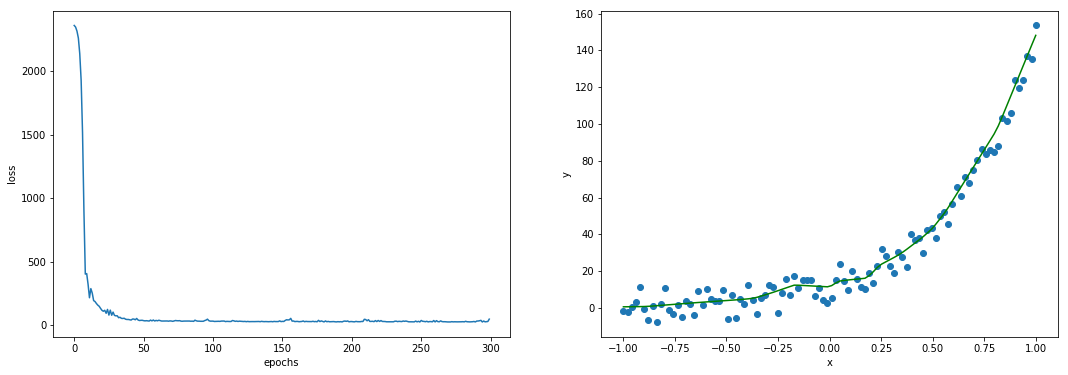

In [ ]:
# Equação de Exponencial - Regressão Exponencial ->>> xxxxxxxxx3 - 10x

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=100, activation='relu', input_shape=(1, )))
model.add(tf.keras.layers.Dense(units=100, activation='relu'))
model.add(tf.keras.layers.Dense(units=180, activation='relu'))
model.add(tf.keras.layers.Dense(units=180, activation='relu'))
model.add(tf.keras.layers.Dense(units=180, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='linear'))
model.summary()

model.compile(optimizer='adam', loss='mse')

hist = model.fit(x, y, epochs=300, verbose=1)

plot_hist_and_line(hist.history, x, y, model)

# Classificação Binária

## Blobs

(100, 2) (100, 1)


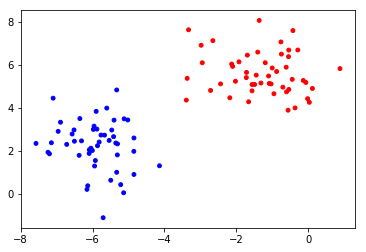

In [ ]:
x, y = make_blobs(n_samples=100, n_features=2, centers=2, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

Epoch 1/150
100/100 [==============================] - 0s 896us/sample - loss: 1.2815 - accuracy: 0.5000
Epoch 2/150
100/100 [==============================] - 0s 99us/sample - loss: 1.2187 - accuracy: 0.5000
Epoch 3/150
100/100 [==============================] - 0s 106us/sample - loss: 1.1583 - accuracy: 0.5000
Epoch 4/150
100/100 [==============================] - 0s 106us/sample - loss: 1.1045 - accuracy: 0.5000
Epoch 5/150
100/100 [==============================] - 0s 106us/sample - loss: 1.0515 - accuracy: 0.5000
Epoch 6/150
100/100 [==============================] - 0s 106us/sample - loss: 1.0027 - accuracy: 0.5000
Epoch 7/150
100/100 [==============================] - 0s 136us/sample - loss: 0.9610 - accuracy: 0.5000
Epoch 8/150
100/100 [==============================] - 0s 112us/sample - loss: 0.9182 - accuracy: 0.5000
Epoch 9/150
100/100 [==============================] - 0s 135us/sample - loss: 0.8770 - accuracy: 0.5000
Epoch 10/150
100/100 [==============================] - 

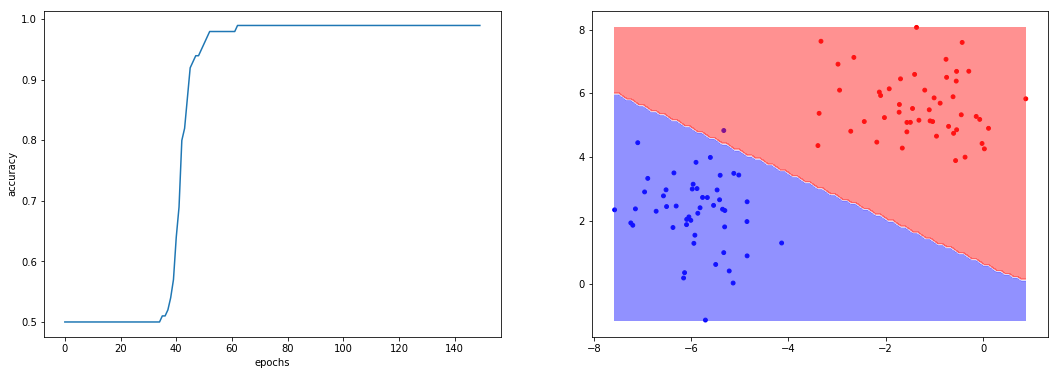

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=15, activation='relu', input_shape=(2, )))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

hist = model.fit(x, y, batch_size=16, epochs=150, verbose=1)


plot_hist_and_predictions(hist.history, x, y, model, cmap='bwr')

## 4 Clusters

(500, 2) (500, 1)


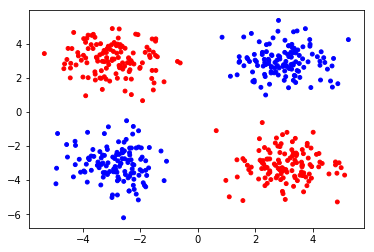

In [ ]:
x, y = make_blobs(n_samples=500, n_features=2, cluster_std=0.9, centers=[(-3, -3), (3, 3), (-3, 3), (3, -3)], random_state=1234)
y = y.reshape(-1, 1)
y = np.where(y >= 2, 1, 0)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

Epoch 1/150
500/500 [==============================] - 0s 181us/sample - loss: 0.8575 - accuracy: 0.5220
Epoch 2/150
500/500 [==============================] - 0s 43us/sample - loss: 0.7593 - accuracy: 0.5600
Epoch 3/150
500/500 [==============================] - 0s 39us/sample - loss: 0.6740 - accuracy: 0.6120
Epoch 4/150
500/500 [==============================] - 0s 43us/sample - loss: 0.5980 - accuracy: 0.6620
Epoch 5/150
500/500 [==============================] - 0s 50us/sample - loss: 0.5348 - accuracy: 0.6960
Epoch 6/150
500/500 [==============================] - 0s 43us/sample - loss: 0.4792 - accuracy: 0.7160
Epoch 7/150
500/500 [==============================] - 0s 40us/sample - loss: 0.4331 - accuracy: 0.7500
Epoch 8/150
500/500 [==============================] - 0s 38us/sample - loss: 0.3933 - accuracy: 0.8440
Epoch 9/150
500/500 [==============================] - 0s 39us/sample - loss: 0.3583 - accuracy: 0.9080
Epoch 10/150
500/500 [==============================] - 0s 39us

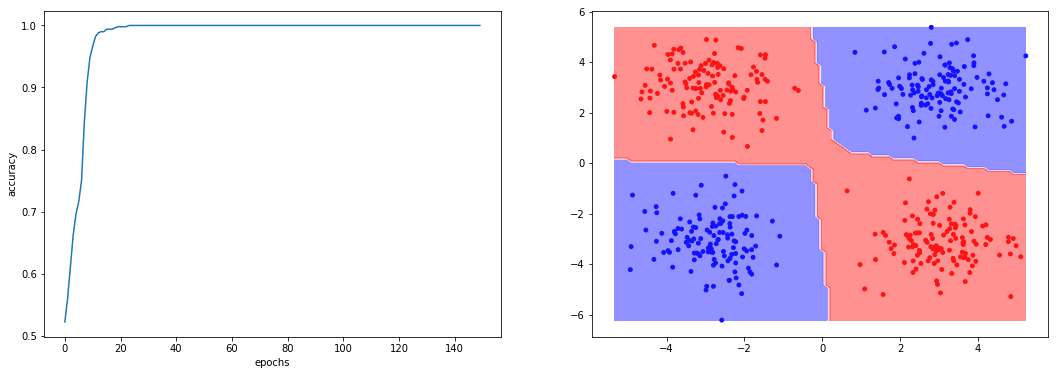

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=10, activation='relu', input_shape=(2, )))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

hist = model.fit(x, y, batch_size=32, epochs=150, verbose=1)


plot_hist_and_predictions(hist.history, x, y, model, cmap='bwr')

## Círculos

(500, 2) (500, 1)


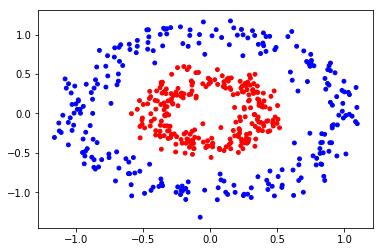

In [ ]:
x, y = make_circles(n_samples=500, noise=0.1, factor=0.4, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 14)                42        
_________________________________________________________________
dense_21 (Dense)             (None, 10)                150       
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 11        
Total params: 203
Trainable params: 203
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
500/500 [==============================] - 0s 208us/sample - loss: 0.6873 - accuracy: 0.4920
Epoch 2/150
500/500 [==============================] - 0s 44us/sample - loss: 0.6724 - accuracy: 0.5160
Epoch 3/150
500/500 [==============================] - 0s 41us/sample - loss: 0.6585 - accuracy: 0.5540
Epoch 4/150
500/500 [==============================] - 0s 45us/sample - 

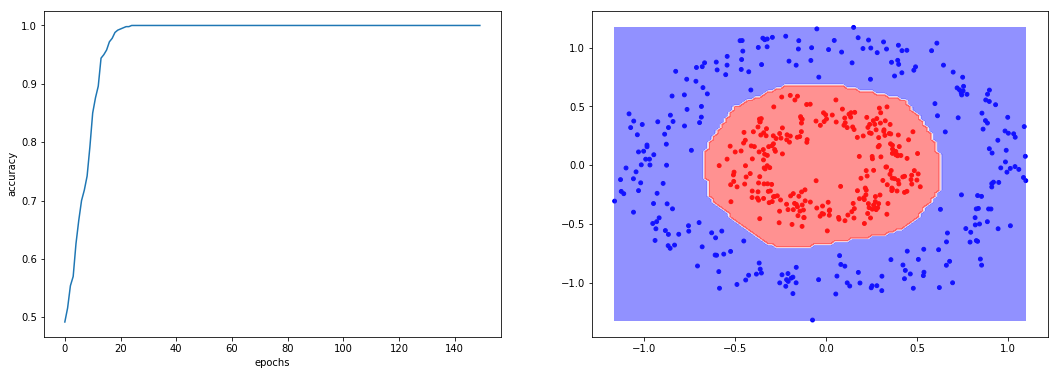

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=14, activation='relu', input_shape=(2, )))
model.add(tf.keras.layers.Dense(units=10, activation='relu', input_shape=(2, )))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

hist = model.fit(x, y, batch_size=32, epochs=150, verbose=1)


plot_hist_and_predictions(hist.history, x, y, model, cmap='bwr')

## Moons

(200, 2) (200, 1)


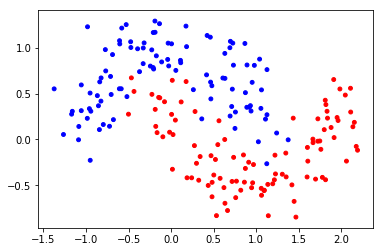

In [ ]:
x, y = make_moons(200, noise=0.20)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 170)               510       
_________________________________________________________________
dense_30 (Dense)             (None, 190)               32490     
_________________________________________________________________
dense_31 (Dense)             (None, 190)               36290     
_________________________________________________________________
dense_32 (Dense)             (None, 190)               36290     
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 191       
Total params: 105,771
Trainable params: 105,771
Non-trainable params: 0
_________________________________________________________________
Epoch 1/350
200/200 [==============================] - 0s 662us/sample - loss: 0.6297 - accuracy: 0.8300
Epoch 2/

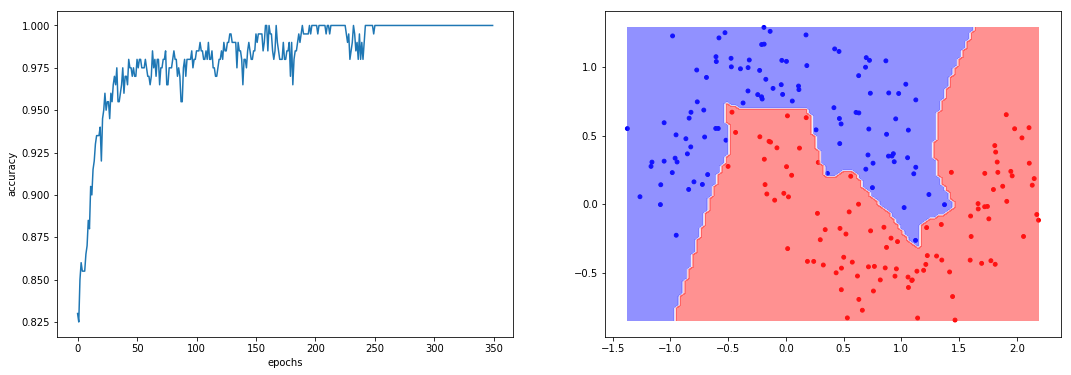

In [ ]:

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=170, activation='relu', input_shape=(2, )))
model.add(tf.keras.layers.Dense(units=190, activation='relu', input_shape=(2, )))
model.add(tf.keras.layers.Dense(units=190, activation='relu', input_shape=(2, )))
model.add(tf.keras.layers.Dense(units=190, activation='relu', input_shape=(2, )))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

hist = model.fit(x, y, batch_size=32, epochs=350, verbose=1)



plot_hist_and_predictions(hist.history, x, y, model, cmap='bwr')

## Espiral

(200, 2) (200, 1)


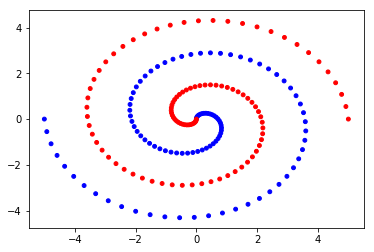

In [ ]:
x, y = make_spiral(n_samples=100, n_class=2, radius=5, laps=1.75)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_93 (Dense)             (None, 240)               720       
_________________________________________________________________
dense_94 (Dense)             (None, 100)               24100     
_________________________________________________________________
dense_95 (Dense)             (None, 180)               18180     
_________________________________________________________________
dense_96 (Dense)             (None, 100)               18100     
_________________________________________________________________
dense_97 (Dense)             (None, 190)               19190     
_________________________________________________________________
dense_98 (Dense)             (None, 200)               38200     
_________________________________________________________________
dense_99 (Dense)             (None, 1)               

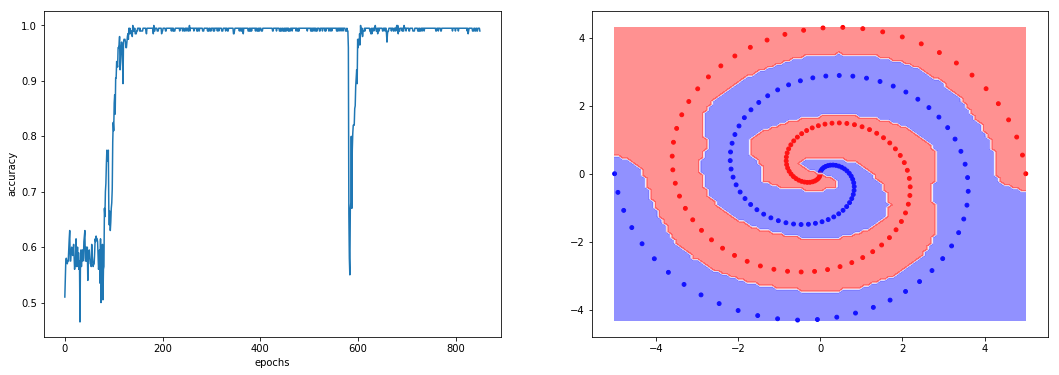

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=240, activation='elu', input_shape=(2, )))
model.add(tf.keras.layers.Dense(units=100, activation='elu', input_shape=(2, )))
model.add(tf.keras.layers.Dense(units=180, activation='elu', input_shape=(2, )))
model.add(tf.keras.layers.Dense(units=100, activation='elu', input_shape=(2, )))
model.add(tf.keras.layers.Dense(units=190, activation='elu', input_shape=(2, )))
model.add(tf.keras.layers.Dense(units=200, activation='elu', input_shape=(2, )))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

hist = model.fit(x, y, batch_size=32, epochs=850, verbose=2)

plot_hist_and_predictions(hist.history, x, y, model, cmap='bwr')

# Classificação Multiclasse

## 3 Clusters

(300, 2) (300, 1)


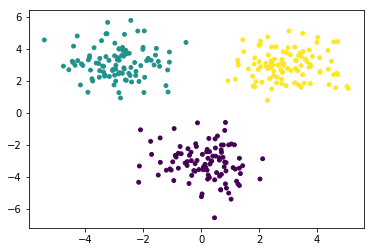

In [ ]:
x, y = make_blobs(n_samples=300, n_features=2, centers=[(0, -3), (-3, 3), (3, 3)], random_state=1234)
y = y.reshape(-1, 1)
print(x.shape, y.shape)

plt.scatter(x[:, 0], x[:, 1], c=y.flatten(), s=15)

Epoch 1/50
300/300 [==============================] - 0s 256us/sample - loss: 1.3585 - accuracy: 0.6500
Epoch 2/50
300/300 [==============================] - 0s 44us/sample - loss: 1.2180 - accuracy: 0.6633
Epoch 3/50
300/300 [==============================] - 0s 45us/sample - loss: 1.0867 - accuracy: 0.6667
Epoch 4/50
300/300 [==============================] - 0s 53us/sample - loss: 0.9671 - accuracy: 0.6667
Epoch 5/50
300/300 [==============================] - 0s 46us/sample - loss: 0.8622 - accuracy: 0.6667
Epoch 6/50
300/300 [==============================] - 0s 43us/sample - loss: 0.7657 - accuracy: 0.6700
Epoch 7/50
300/300 [==============================] - 0s 47us/sample - loss: 0.6798 - accuracy: 0.6800
Epoch 8/50
300/300 [==============================] - 0s 53us/sample - loss: 0.6033 - accuracy: 0.7467
Epoch 9/50
300/300 [==============================] - 0s 46us/sample - loss: 0.5347 - accuracy: 0.8233
Epoch 10/50
300/300 [==============================] - 0s 44us/sample - 

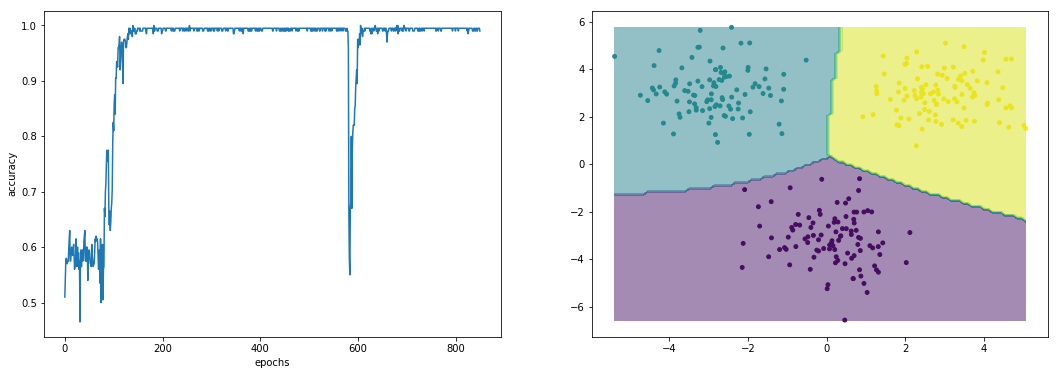

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=10, activation='relu', input_shape=(2, )))
model.add(tf.keras.layers.Dense(units=3, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(x, y, batch_size=32, epochs=50, verbose=1)

plot_hist_and_predictions(hist.history, x, y, model)

## 4 Clusters

(400, 2) (400, 1)


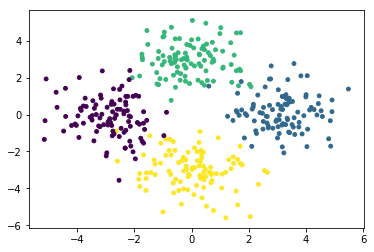

In [ ]:
x, y = make_blobs(n_samples=400, n_features=2, centers=[(-3, 0), (3, 0), (0, 3), (0, -3)], random_state=1234)
y = y.reshape(-1, 1)
print(x.shape, y.shape)

plt.scatter(x[:, 0], x[:, 1], c=y.flatten(), s=15)

Epoch 1/50
400/400 [==============================] - 0s 211us/sample - loss: 1.2261 - accuracy: 0.2975
Epoch 2/50
400/400 [==============================] - 0s 44us/sample - loss: 0.9811 - accuracy: 0.4875
Epoch 3/50
400/400 [==============================] - 0s 43us/sample - loss: 0.8130 - accuracy: 0.6150
Epoch 4/50
400/400 [==============================] - 0s 48us/sample - loss: 0.6852 - accuracy: 0.6725
Epoch 5/50
400/400 [==============================] - 0s 53us/sample - loss: 0.5846 - accuracy: 0.7475
Epoch 6/50
400/400 [==============================] - 0s 43us/sample - loss: 0.4993 - accuracy: 0.8725
Epoch 7/50
400/400 [==============================] - 0s 47us/sample - loss: 0.4285 - accuracy: 0.9350
Epoch 8/50
400/400 [==============================] - 0s 43us/sample - loss: 0.3709 - accuracy: 0.9600
Epoch 9/50
400/400 [==============================] - 0s 43us/sample - loss: 0.3212 - accuracy: 0.9675
Epoch 10/50
400/400 [==============================] - 0s 48us/sample - 

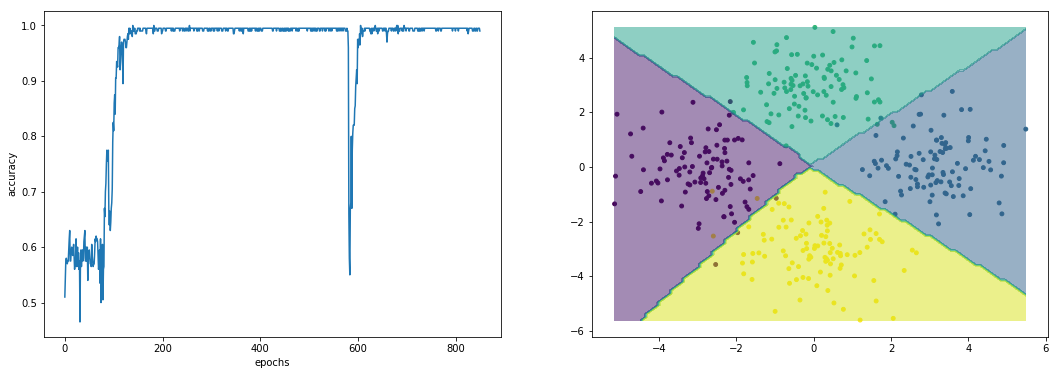

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=19, activation='relu', input_shape=(2, )))
model.add(tf.keras.layers.Dense(units=10, activation='linear', input_shape=(2, )))
model.add(tf.keras.layers.Dense(units=4, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(x, y, batch_size=32, epochs=50, verbose=1)

plot_hist_and_predictions(hist.history, x, y, model)

## Espiral - 5 Classes

(500, 2) (500, 1)


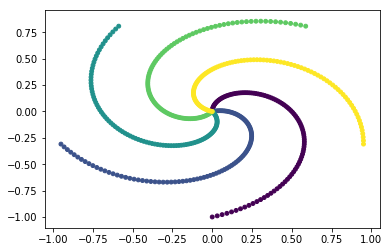

In [ ]:
x, y = make_spiral(n_samples=100, n_class=5, radius=1, laps=0.5)
y = y.reshape(-1, 1)
print(x.shape, y.shape)

plt.scatter(x[:, 0], x[:, 1], c=y.flatten(), s=15)

Epoch 1/250
500/500 [==============================] - 0s 240us/sample - loss: 1.5949 - accuracy: 0.2300
Epoch 2/250
500/500 [==============================] - 0s 28us/sample - loss: 1.5644 - accuracy: 0.4100
Epoch 3/250
500/500 [==============================] - 0s 25us/sample - loss: 1.5351 - accuracy: 0.3920
Epoch 4/250
500/500 [==============================] - 0s 25us/sample - loss: 1.4969 - accuracy: 0.3840
Epoch 5/250
500/500 [==============================] - 0s 31us/sample - loss: 1.4485 - accuracy: 0.3800
Epoch 6/250
500/500 [==============================] - 0s 27us/sample - loss: 1.3924 - accuracy: 0.3880
Epoch 7/250
500/500 [==============================] - 0s 27us/sample - loss: 1.3318 - accuracy: 0.4040
Epoch 8/250
500/500 [==============================] - 0s 29us/sample - loss: 1.2691 - accuracy: 0.4160
Epoch 9/250
500/500 [==============================] - 0s 27us/sample - loss: 1.2062 - accuracy: 0.4400
Epoch 10/250
500/500 [==============================] - 0s 24us

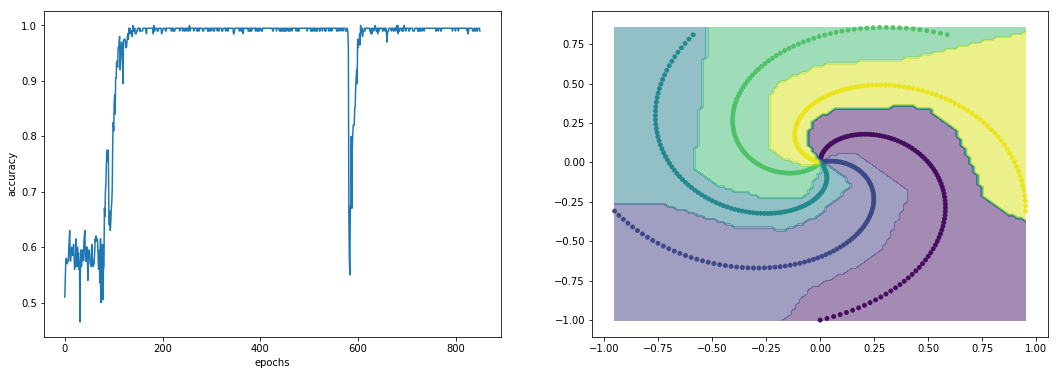

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=19, activation='relu', input_shape=(2, )))
model.add(tf.keras.layers.Dense(units=10, activation='linear', input_shape=(2, )))
model.add(tf.keras.layers.Dense(units=19, activation='relu', input_shape=(2, )))
model.add(tf.keras.layers.Dense(units=10, activation='linear', input_shape=(2, )))
model.add(tf.keras.layers.Dense(units=19, activation='relu', input_shape=(2, )))
model.add(tf.keras.layers.Dense(units=10, activation='linear', input_shape=(2, )))
model.add(tf.keras.layers.Dense(units=5, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(x, y, batch_size=64, epochs=250, verbose=1)

plot_hist_and_predictions(hist.history, x, y, model)

## Make Classification - 4 Classes

(100, 2) (100, 1)


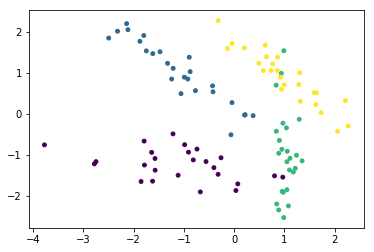

In [ ]:
x, y = make_classification(n_samples=100, n_classes=4, n_features=2, n_clusters_per_class=1, n_redundant=0, n_repeated=0, random_state=1234)
y = y.reshape(-1, 1)
print(x.shape, y.shape)

plt.scatter(x[:, 0], x[:, 1], c=y.flatten(), s=15)

Epoch 1/350
100/100 [==============================] - 0s 1ms/sample - loss: 1.3371 - accuracy: 0.2700
Epoch 2/350
100/100 [==============================] - 0s 67us/sample - loss: 1.3026 - accuracy: 0.3200
Epoch 3/350
100/100 [==============================] - 0s 59us/sample - loss: 1.2698 - accuracy: 0.3800
Epoch 4/350
100/100 [==============================] - 0s 49us/sample - loss: 1.2391 - accuracy: 0.5200
Epoch 5/350
100/100 [==============================] - 0s 47us/sample - loss: 1.2099 - accuracy: 0.5800
Epoch 6/350
100/100 [==============================] - 0s 53us/sample - loss: 1.1826 - accuracy: 0.5900
Epoch 7/350
100/100 [==============================] - 0s 48us/sample - loss: 1.1559 - accuracy: 0.5900
Epoch 8/350
100/100 [==============================] - 0s 48us/sample - loss: 1.1299 - accuracy: 0.6000
Epoch 9/350
100/100 [==============================] - 0s 43us/sample - loss: 1.1058 - accuracy: 0.6200
Epoch 10/350
100/100 [==============================] - 0s 49us/s

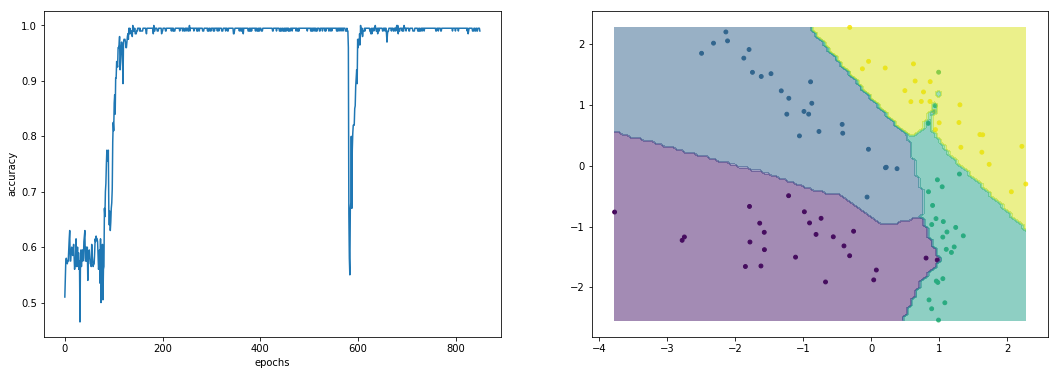

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=10, activation='relu', input_shape=(2, )))
model.add(tf.keras.layers.Dense(units=10, activation='linear', input_shape=(2, )))
model.add(tf.keras.layers.Dense(units=19, activation='relu', input_shape=(2, )))
model.add(tf.keras.layers.Dense(units=10, activation='linear', input_shape=(2, )))
model.add(tf.keras.layers.Dense(units=19, activation='relu', input_shape=(2, )))
model.add(tf.keras.layers.Dense(units=10, activation='linear', input_shape=(2, )))
model.add(tf.keras.layers.Dense(units=4, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(x, y, batch_size=64, epochs=350, verbose=1)
model.summary()

plot_hist_and_predictions(hist.history, x, y, model)

## MNIST - 10 classes

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


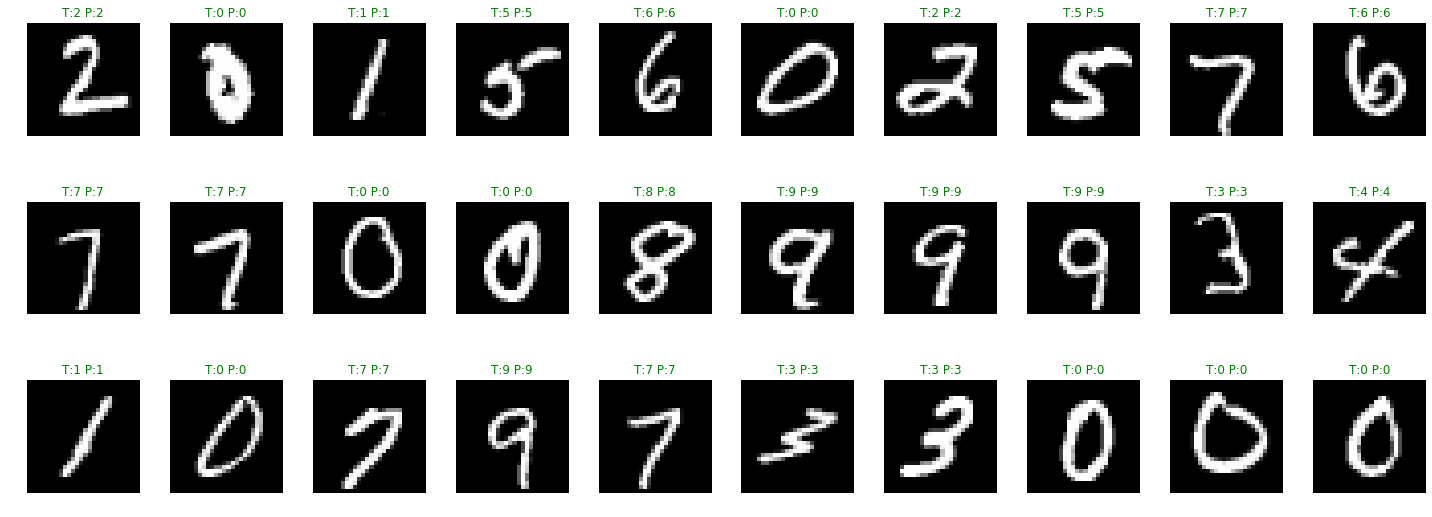

In [ ]:
plot_random_batch(x_train, y_train)

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
model.add(tf.keras.layers.Dense(units=584, activation='relu'))
model.add(tf.keras.layers.Dense(units=124, activation='relu'))
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

hist = model.fit(x_train / 255, y_train, batch_size=32, epochs=2)
model.evaluate(x_test / 255, y_test)


Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_183 (Dense)            (None, 584)               458440    
_________________________________________________________________
dense_184 (Dense)            (None, 124)               72540     
_________________________________________________________________
dense_185 (Dense)            (None, 10)                1250      
Total params: 532,230
Trainable params: 532,230
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
60000/60000 [==============================] - 8s 136us/sample - loss: 0.1856 - accuracy: 0.9434
Epoch 2/2
10000/10000 [==============================] - 1s 63us/sample - loss: 0.0878 - accuracy: 0.9725


[0.08776828612815589, 0.9725]

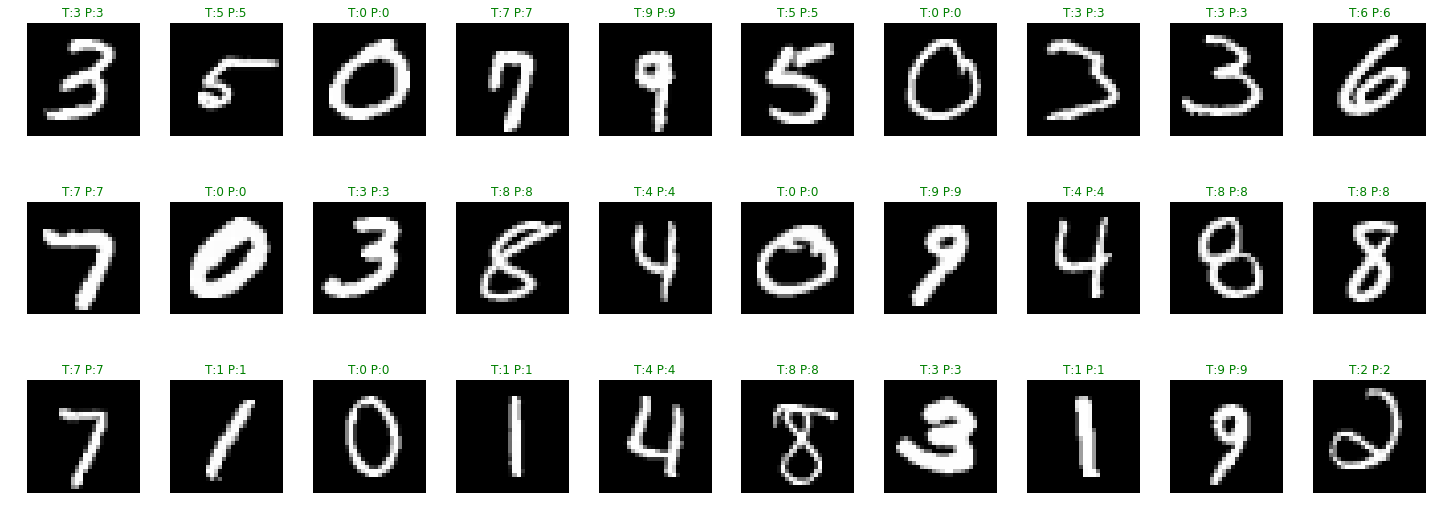

In [ ]:
y_pred = model.predict_classes(x_test / 255)

plot_random_batch(x_test, y_test, y_pred)

# Rede Convolucional

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = np.expand_dims(x_train, axis=-1), np.expand_dims(x_test, axis=-1)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)


In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=(28, 28, 1)))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

model.add(tf.keras.layers.Flatten()) # Camada de Flatten..

# Aplicar uma camada para otimizar (Camada Densa)
model.add(tf.keras.layers.Dense(units=20, activation='relu'))
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))

# compilar o modelo..

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Treinar o modelo..
model.fit(x_train / 255,  y_train, batch_size=32, epochs=1, validation_split=0.3)
model.evaluate(x_test / 255, y_test)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 28, 28, 8)         80        
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 16)        1168      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 7, 7, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 20)                15700     
_________________________________________________________________
dense_15 (Dense)             (None, 10)               

[0.11145883639417589, 0.9645]

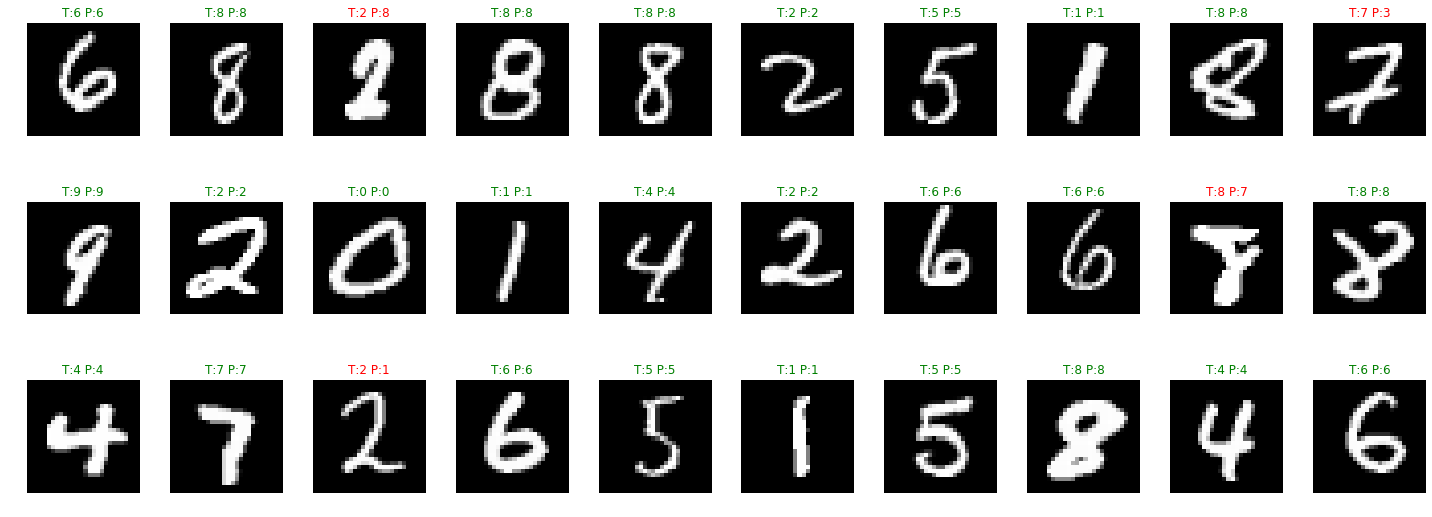

In [ ]:
y_pred = model.predict_classes(x_test / 255)

plot_random_batch(x_test, y_test, y_pred)